In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!bash /content/Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab190912.sh
!apt -qq -y install fonts-nanum

     |████████████████████████████████| 19.4MB 52.9MB/s 
     |████████████████████████████████| 92kB 8.6MB/s 
     |████████████████████████████████| 460kB 53.4MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-04-24 02:57:44--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::6b17:d1f5, 2406:da00:ff00::22cd:e0db, ...
Connecting to bitbucket.org (bitbucke

In [3]:

import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()


import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
print(tf.__version__)

2.4.1


In [4]:
dev_data_path = '/content/drive/MyDrive/DL_Study/AIFFEL/GoingDeeper/Seq2Seq_Kor_Eng/korean-english-dev/korean-english-park.dev/'
test_data_path = '/content/drive/MyDrive/DL_Study/AIFFEL/GoingDeeper/Seq2Seq_Kor_Eng/korean-english-park-test/korean-english-park.test/'
train_data_path = '/content/drive/MyDrive/DL_Study/AIFFEL/GoingDeeper/Seq2Seq_Kor_Eng/korean-english-park-train/korean-english-park.train/'
dev_en_filename = 'korean-english-park.dev.en'
dev_ko_filename = 'korean-english-park.dev.ko'
test_en_filename = 'korean-english-park.test.en'
test_ko_filename = 'korean-english-park.test.ko'
train_en_filename = 'korean-english-park.train.en'
train_ko_filename = 'korean-english-park.train.ko'

vocab_size = 20000

In [5]:
enc_corpus = []
dec_corpus = []

with open(train_data_path+train_en_filename, "r") as f:
    raw_en = f.read().splitlines()

with open(train_data_path+train_ko_filename, "r") as f:
    raw_ko = f.read().splitlines()

print('영어 데이터 크기 = %d'%len(raw_en))
print('한국어 데이터 크기 = %d'%len(raw_ko))

영어 데이터 크기 = 94123
한국어 데이터 크기 = 94123


In [6]:
# 아래 코드 검증용
cleaned_corpus = list(set(raw_ko))
print("Data Size:", len(cleaned_corpus))

Data Size: 77591


In [7]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


In [8]:
import pandas as pd

# index에 해당하는 각각의 요소를 True, False mask list로 만들어준다.
index_mask = pd.Index(raw_ko).duplicated(keep='first')
ko_remove_dup = [raw_ko[index] for index, v in enumerate(index_mask)\
                             if not v]
en_remove_dup = [raw_en[index] for index, v in enumerate(index_mask)\
                             if not v]

index_mask = pd.Index(en_remove_dup).duplicated(keep='first')
ko_remove_dup = [raw_ko[index] for index, v in enumerate(index_mask)\
                             if not v]
en_remove_dup = [raw_en[index] for index, v in enumerate(index_mask)\
                             if not v]

raw_ko = ko_remove_dup
raw_en = en_remove_dup

print('중복제거후')
print('영어 데이터 크기 = %d'%len(raw_en))
print('한국어 데이터 크기 = %d'%len(raw_ko))



중복제거후
영어 데이터 크기 = 74849
한국어 데이터 크기 = 74849


In [9]:
max_len = 40
min_len = 10
# data preprocessing
print('길이를 베이스로 전처리하기전 corpus크기는 %d'%len(raw_en))
filtered_mask = [len(value) for value in raw_en]
filtered_mask = np.array(filtered_mask)
filtered_mask = np.where((filtered_mask < max_len) \
                             & (filtered_mask >= min_len), True, False) 
en_filtered_corpus = [raw_en[index] for index, v in enumerate(filtered_mask)\
                             if v]
ko_filtered_corpus = [raw_ko[index] for index, v in enumerate(filtered_mask)\
                             if v]

filtered_mask = [len(value) for value in raw_ko]
filtered_mask = np.array(filtered_mask)
filtered_mask = np.where((filtered_mask < max_len) \
                             & (filtered_mask >= min_len), True, False) 
en_filtered_corpus = [raw_en[index] for index, v in enumerate(filtered_mask)\
                             if v]
ko_filtered_corpus = [raw_ko[index] for index, v in enumerate(filtered_mask)\
                             if v]

print('전처리 후 corpus크기는 %d'%len(en_filtered_corpus))
print('전처리 후 corpus크기는 %d'%len(ko_filtered_corpus))

길이를 베이스로 전처리하기전 corpus크기는 74849
전처리 후 corpus크기는 18045
전처리 후 corpus크기는 18045


In [10]:
# data_size = 50000
# en_filtered_corpus = en_filtered_corpus[:data_size]
# ko_filtered_corpus = ko_filtered_corpus[:data_size]

In [11]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = re.sub(r"[^0-9a-zA-Zㄱ-ㅎㅣ가-힣?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [12]:
enc_corpus = []
dec_corpus = []

for pair in zip(ko_filtered_corpus,en_filtered_corpus):
    enc_corpus.append(preprocess_sentence(pair[0]))
    dec_corpus.append(preprocess_sentence(pair[1], s_token=True, e_token=True))

print("Korean:", enc_corpus[100])   # go away !
print("English:", dec_corpus[100])   # <start> salga de aqu ! <end>

Korean: 그들이 아주 몸집이 크고 강인해야 할 필요는 없습니다 .
English: <start> they don t have to be very big and strong . <end>


In [13]:
from konlpy.tag import Mecab

mecab = Mecab()

def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

def tokenize_kor(corpus):
  mecab_corpus = []

  def mecab_split(sentence):
    temp_X = []
    temp_X = mecab.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거

    return temp_X

  for kor in corpus:
    mecab_corpus.append(mecab_split(kor))

  return tokenize(mecab_corpus)



In [14]:
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("Korean Vocab Size: ", len(enc_tokenizer.index_word))
print("English Vocab Size: ", len(dec_tokenizer.index_word))

Korean Vocab Size:  31436
English Vocab Size:  14612


In [33]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = Dropout(0.2, name='Dropout')
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.dropout(out)
        out = self.gru(out)

        return out

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = Dropout(0.2, name='Dropout')
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = self.dropout(out)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [34]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

NameError: ignored

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [35]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [36]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch  7:  32%|███▏      | 72/226 [00:43<01:32,  1.66it/s, Loss 0.0661]

Epoch  7:  32%|███▏      | 72/226 [00:43<01:32,  1.66it/s, Loss 0.0663]

Epoch  7:  32%|███▏      | 73/226 [00:43<01:31,  1.68it/s, Loss 0.0663]

Epoch  7:  32%|███▏      | 73/226 [00:43<01:31,  1.68it/s, Loss 0.0663]

Epoch  7:  32%|███▏      | 73/226 [00:43<01:31,  1.68it/s, Loss 0.0666]

Epoch  7:  33%|███▎      | 74/226 [00:43<01:31,  1.67it/s, Loss 0.0666]

Epoch  7:  33%|███▎      | 74/226 [00:44<01:31,  1.67it/s, Loss 0.0666]

Epoch  7:  33%|███▎      | 74/226 [00:44<01:31,  1.67it/s, Loss 0.0668]

Epoch  7:  33%|███▎      | 75/226 [00:44<01:29,  1.69it/s, Loss 0.0668]

Epoch  7:  33%|███▎      | 75/226 [00:45<01:29,  1.69it/s, Loss 0.0668]

Epoch  7:  33%|███▎      | 75/226 [00:45<01:29,  1.69it/s, Loss 0.0668]

Epoch  7:  34%|███▎      | 76/226 [00:45<01:29,  1.68it/s, Loss 0.0668]

Epoch  7:  34%|███▎      | 76/226 [00:45<01:29,  1.68it/s, Loss 0.0668]

Epoch  7:  34%|

In [37]:
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss


# Training Process

from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    test_loss = 0

    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch  8:   8%|▊         | 18/226 [00:11<02:07,  1.63it/s, Loss 0.0278]

Epoch  8:   8%|▊         | 18/226 [00:11<02:07,  1.63it/s, Loss 0.0277]

Epoch  8:   8%|▊         | 19/226 [00:11<02:07,  1.62it/s, Loss 0.0277]

Epoch  8:   8%|▊         | 19/226 [00:12<02:07,  1.62it/s, Loss 0.0277]

Epoch  8:   8%|▊         | 19/226 [00:12<02:07,  1.62it/s, Loss 0.0281]

Epoch  8:   9%|▉         | 20/226 [00:12<02:07,  1.62it/s, Loss 0.0281]

Epoch  8:   9%|▉         | 20/226 [00:12<02:07,  1.62it/s, Loss 0.0281]

Epoch  8:   9%|▉         | 20/226 [00:12<02:07,  1.62it/s, Loss 0.0282]

Epoch  8:   9%|▉         | 21/226 [00:12<02:06,  1.62it/s, Loss 0.0282]

Epoch  8:   9%|▉         | 21/226 [00:13<02:06,  1.62it/s, Loss 0.0282]

Epoch  8:   9%|▉         | 21/226 [00:13<02:06,  1.62it/s, Loss 0.0282]

Epoch  8:  10%|▉         | 22/226 [00:13<02:05,  1.63it/s, Loss 0.0282]

Epoch  8:  10%|▉         | 22/226 [00:13<02:05,  1.63it/s, Loss 0.0282]

Epoch  8:  10%|

In [38]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))




Input: 오바마는 대통령이다 .
Predicted translation: obama had been courting edwards for four months on wednesday also made some gains in key battleground states . <end> 


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45716 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53685 missing from current font.
  font.set_

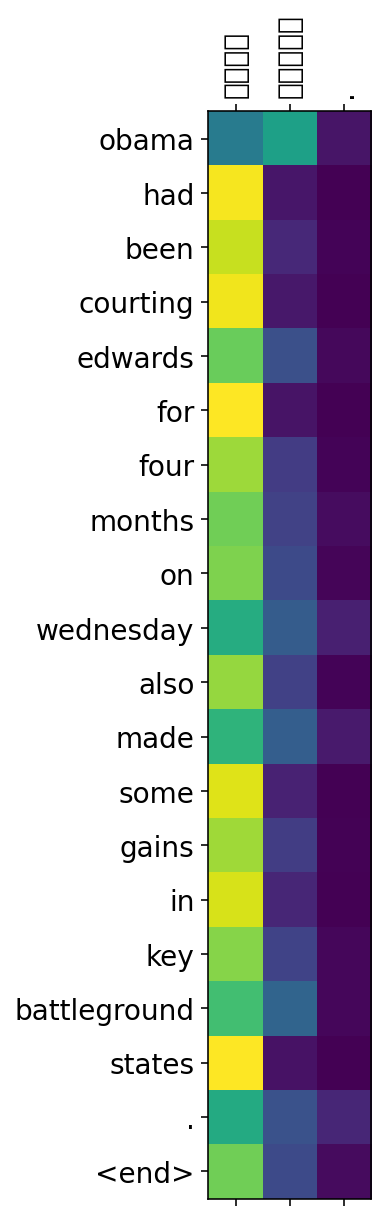

In [39]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: they even that year . <end> 


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48124 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46308 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51008 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49549 missing from current font.
  font.set_

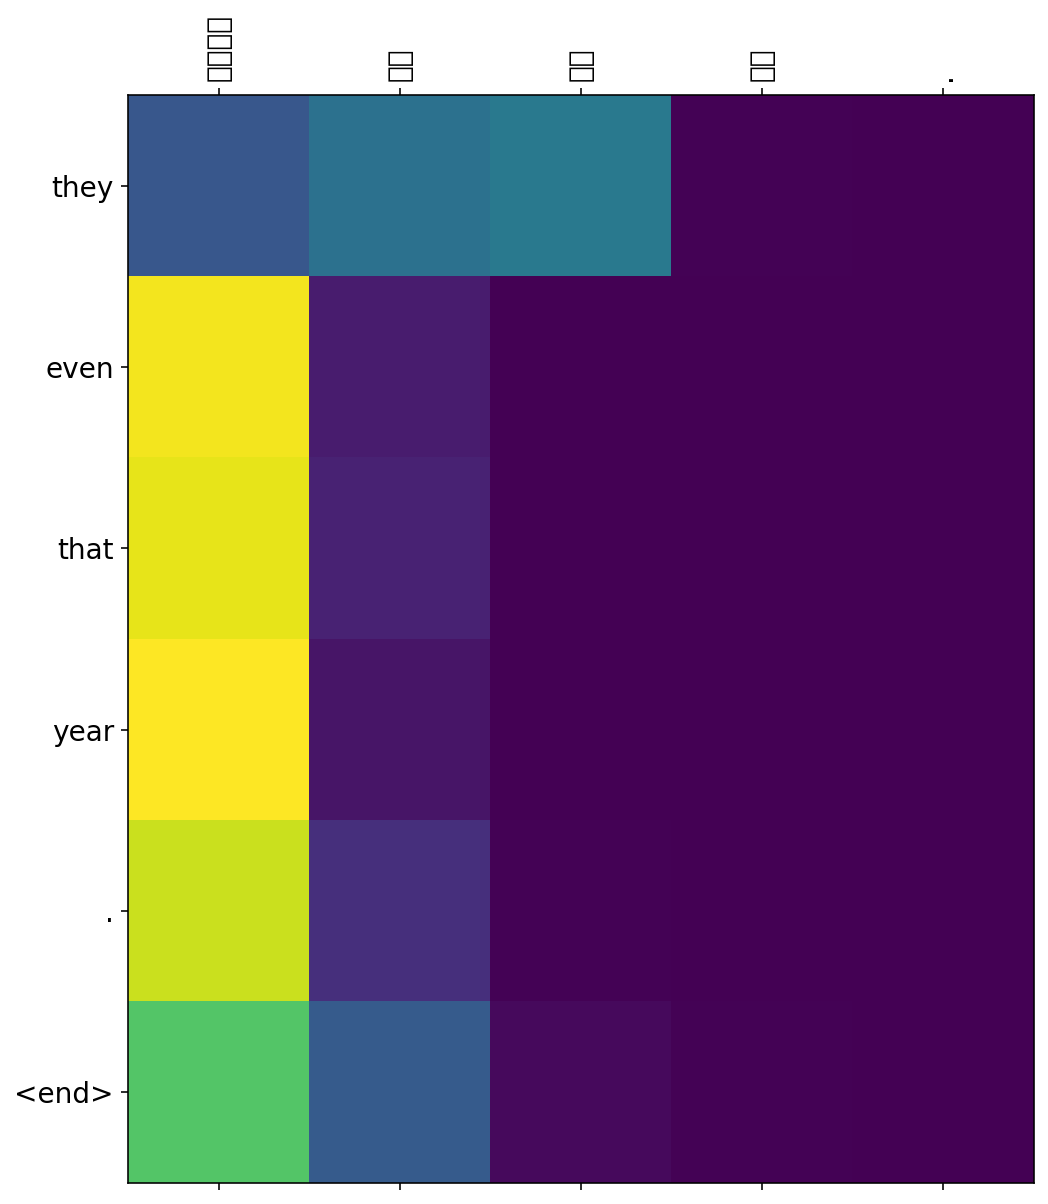

Input: 오바마는 대통령이다 .
Predicted translation: obama had been courting edwards for four months on wednesday also made some gains in key battleground states . <end> 


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45716 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53685 missing from current font.
  font.set_

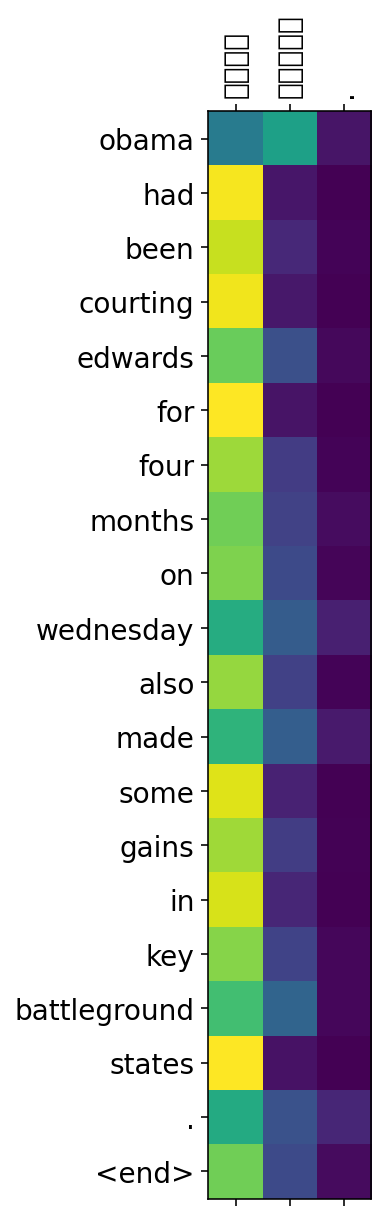

Input: 커피는 필요 없다 .
Predicted translation: news forces . <end> 


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52964 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54596 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50630 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52964 missing from current font.
  font.set_

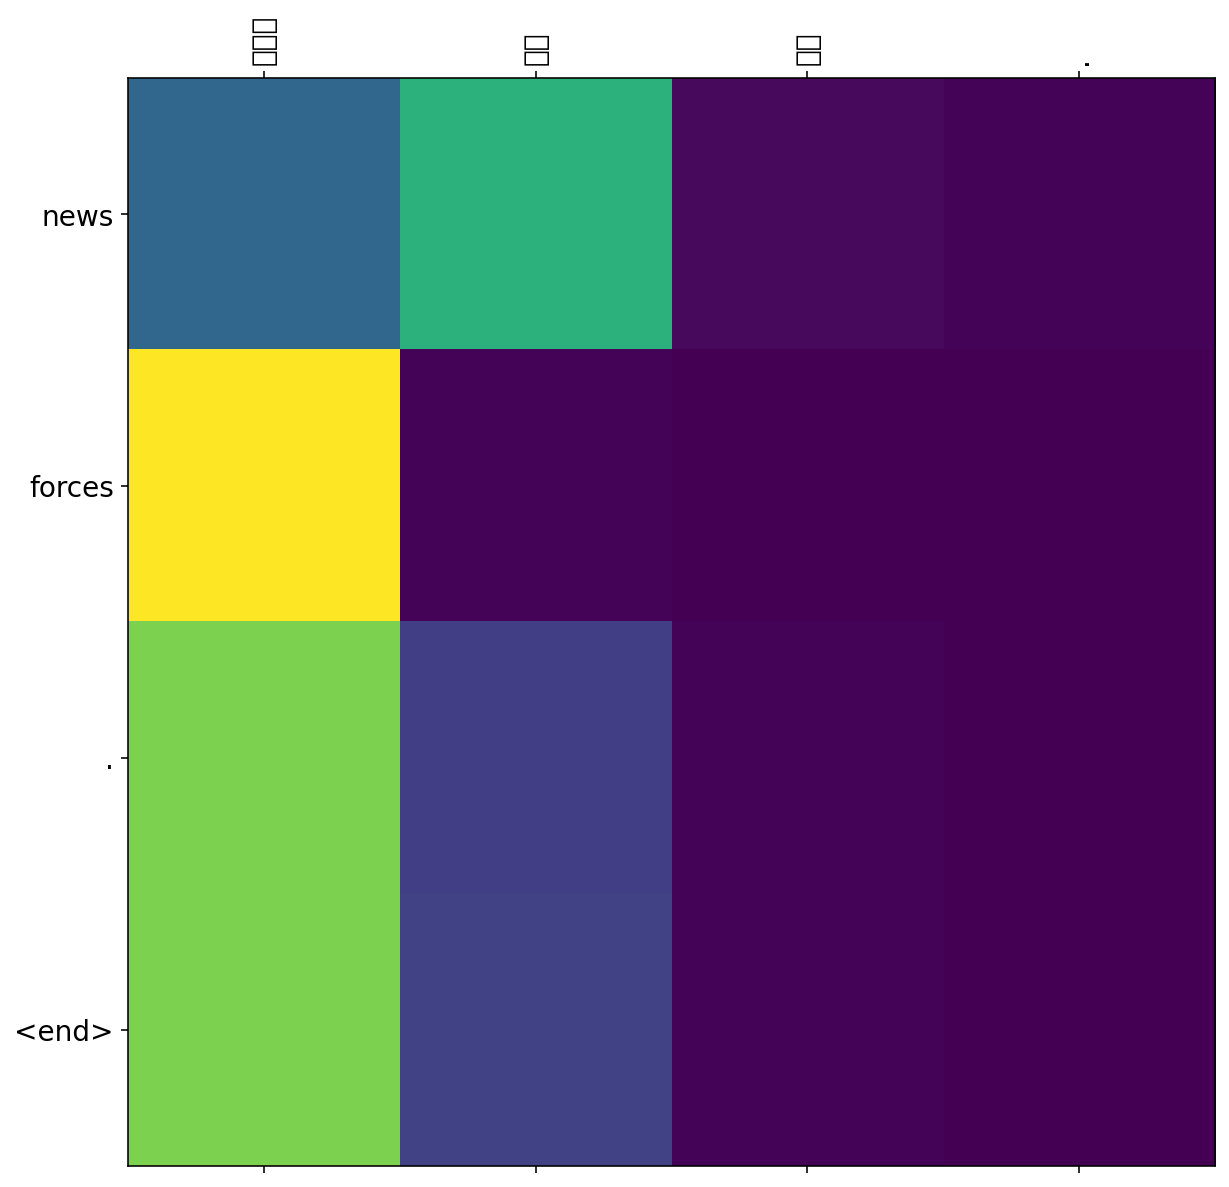

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: at least 10 of the seven astronauts were married , and five of the seven astronauts were married , and five of the seven astronauts were married , and five of the seven astronauts were married , and five of the seven astronauts were married , and five of the seven astronauts were married , and five of the seven astronauts were married , and five of the 


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44273 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47581 missing from current font.
  font.set_

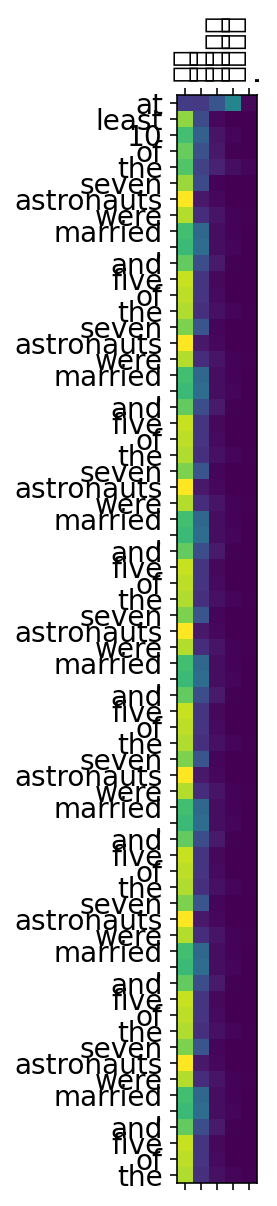

In [40]:
def test_my_model(kor_input):
  for sen in kor_input:
    translate(sen, encoder, decoder)


inputs=['시민들은 도시 속에 산다.', '오바마는 대통령이다.', '커피는 필요 없다.', '일곱 명의 사망자가 발생했다.']

test_my_model(inputs)